# PK Date & Time Reconciliation

In [1]:
import csv
import json
import pprint
import datetime
import os
import re
from matplotlib import pyplot

%matplotlib inline

## Setup Output Folder

_Global_ scope variables:

In [2]:
outputfolder = './test/pk/output'

Create the __output folder__ in which all output files will be placed.

In [3]:
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder, 0o755) # owner execution 

View contents of folder:

In [4]:
%ls -l ./test

total 0
drwxr-xr-x  9 herbsca  staff  288 17 Apr 11:48 pk/
drwxr-xr-x  3 herbsca  staff   96 17 Apr 11:20 safety/


Define output file writing functions:

In [5]:
def writeFile(filename: str, contents: object):
    # Create function to allow for file creation in output.
    path = os.path.join(outputfolder, filename)
    with open(path, 'w') as outputfile:
        outputfile.write(pprint.pformat(contents))

def writeJSON(filename: str, contents: object):
    # Create function to allow for file creation in output.
    path = os.path.join(outputfolder, filename)
    with open(path, 'w') as outputfile:
        outputfile.write(json.dumps(contents))
        
def writeErrorCSV(filename: str, contents: object):
    path = os.path.join(outputfolder, filename)
    with open(path, 'w') as outputfile:
        fieldnames = ['subjectid', 'period', 'timepoint', 'sourceDate', 'sourceTime', 'pkDate', 'pkTime', 'message']
        writer = csv.DictWriter(outputfile, fieldnames=fieldnames)
        writer.writeheader() # place headers in csv file.
        for key in contents:
            if key == 'errors' or  key  == 'total':
                    continue
            for data in contents[key]:
                # cycle through list of errors
                sourcedate = '-'
                sourcetime = '-'
                pkdate = '-'
                pktime = '-'
                msg =  ''
                if data['date']['error']:
                    sourcedate = data['date']['source']
                    pkdate = data['date']['pk']
                if data['time']['error']:
                    sourcetime = data['time']['source']
                    pktime = data['time']['pk']
                if 'msg' in data:
                    msg = data['msg']

                row = {
                    'subjectid': data['subjectid'],
                    'period': data['period'],
                    'timepoint': data['timepoint'],
                    'sourceDate': sourcedate,
                    'sourceTime': sourcetime,
                    'pkDate': pkdate,
                    'pkTime': pktime,
                    'message': msg
                }
                writer.writerow(row) # write to file
    print('CSV write complete.')

## Create Mapping

Map csv file records to the csv file records of medrio using the randomisation number. This _ipython_ cell attempts to avoid the user manually having to specify the mapping of each subject to data, instead just provide a file that maps a certain __Subject ID__ to a certain __Randomisation Number__.

In [1]:
# [TODO] Define the file path to the randomisation number to subject-id mapping
rand_filename: str = './test/pk/rand_coh1.csv'

subjectMap = dict() # dictionary for randomisation to subject id.

# [TODO] - Column header for randomisation number
randCol = 'DARandNum_C'

# [TODO] - Column header for subject id
subjectCol = 'Subject ID' 

# Read the file
with open(rand_filename) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        subjectMap[f'{row[randCol]}'] = row[subjectCol]

writeFile('subjectMapping.txt', subjectMap)

FileNotFoundError: [Errno 2] No such file or directory: './test/pk/rand_coh1.csv'

## Read Configuration File

Parse config file and establish relationships.

In [8]:
# [TODO] - Specify the file path to the config file
config_filename = './test/pk/config.json'

configDict = dict()

with open(config_filename) as jsonfile:
    configDict = json.load(jsonfile)

pprint.pp(configDict)

{'source': {'file': './INPUT.csv'},
 'comparison': {'file': './COMPARISON.csv'},
 'output': {'directory': './output'},
 'match': {'0': {'date': 'PKPDDat_C', 'time': 'PKPDTim_C'},
           '0.25': {'date': 'PK15Dat_C', 'time': 'PK15Tim_C'},
           '0.5': {'date': 'PK30Dat_C', 'time': 'PK30Tim_C'},
           '1': {'date': 'PK1Dat_C', 'time': 'PK1Tim_C'},
           '1.5': {'date': 'PK90Dat_C', 'time': 'PK90Tim_C'},
           '2': {'date': 'PK2Dat_C', 'time': 'PK2Tim_C'},
           '3': {'date': 'PKPM0Dat_C', 'time': 'PKPMTim_C'},
           '4': {'date': 'PK4Dat_C', 'time': 'PK4Tim_C'},
           '5': {'date': 'PK5Dat_C', 'time': 'PK5Tim_C'},
           '6': {'date': 'PK6Dat_C', 'time': 'PK6Tim_C'},
           '8': {'date': 'PKPM8Dat_C', 'time': 'PKPM8Tim_C'},
           '12': {'date': 'PK12Dat_C', 'time': 'PK12Tim_C'},
           '16': {'date': 'PK16Dat_C', 'time': 'PK16Tim_C'},
           '24': {'date': 'LB24Dat_C', 'time': 'LB24Tim_C'},
           '48': {'date': 'PK48Dat_C',

## Read Medrio Source File

Create dictionary mapping for each subject to allow for hash map search of data.

Context variables:

In [9]:
# [TODO] - Specify the file path to the Medrio source file
source_filename = './test/pk/source_coh1.csv'

# [TODO] - Specify the column header for the subject id details
subjectidcol = 'Subject ID'
# [TODO] - Specify the column header for the visit details
visitCol = 'Visit' # used to find the period

# REGULAR EXPRESSION OBJECTS
# [TODO] - Specify the regular expression that can identify the date column
dateregex = re.compile(r'dat', flags=re.I)

# [TODO] - Specify the regular expression that can identify the time column
timeregex = re.compile(r'tim', flags=re.I)

# [TODO] - Specify the regular expression that can identify the period of the data
# Note: Only applicable to certain studies so comment out if not needed (as well as any other occurences of this variable)
# Use the regular expression "capture groups" to highlight the period number => ([0-9])
periodRegex = re.compile(r'period.*([0-9])', flags=re.I)

Parse the source file and structure data into the __sourceMap__ dictionary variable.

In [10]:
# DICTIONARY FOR SUBJECT DATA
sourceMap = dict()

# READ THE SOURCE FILE
with open(source_filename) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        
        # GET THE PERIOD FOR ROW OF DATA
        match = periodRegex.search(row.get(visitCol).strip())
        if match is None:
            print("Error: Visit period could not be matched.")
            continue
        
        # ADD DATA FOR A PARTICULAR SUBJECT ID INTO THE SOURCE MAP DICTIONARY
        if row[subjectidcol] not in sourceMap:
            sourceMap[f'{row[subjectidcol]}'] = dict()
        if match.group(1) not in sourceMap[f'{row[subjectidcol]}']: # NOTE USES REGEX MATCH FOR GROUP TO DETERMINE THE PERIOD NUMBER (1 OR 2 etc.)
            sourceMap[f'{row[subjectidcol]}'][f'{match.group(1)}'] = dict()
        
        # WRITE DATA VALUES TO SOURCE
        # CYCLE THROUGH EACH COLUMN IN ROW
        for key in row:
            if row[key] == '': # EMPTY
                continue
            value = None
            if dateregex.search(key) is not None:
                # DATE VARIABLE
                value = datetime.datetime.strptime(row.get(key).strip(), '%m/%d/%Y')
            elif timeregex.search(key) is not None:
                # TIME VARIABLE
                value = datetime.datetime.strptime(row.get(key).strip(), '%H:%M')
            else:
                # INCLUDE EXTRA VARIABLES
                value = row.get(key, '')
            
            sourceMap[f'{row[subjectidcol]}'][f'{match.group(1)}'][f'{key}'] = value # WRITE VALUE TO SOURCE MAP

writeFile('source_data_debugging.txt', sourceMap) # OUTPUT MEDRIO DEBUGGING FILE

## Source Map Dictionary Structure

```
{
    "subject_id": {
        "period_id": {
            "medrio_variable": {
                "date": date-object,
                "time": time-object,
                ...
             },
             ...
         },
         ...
     },
     ...
}
```

## Read Comparison File

Context variables:

In [11]:
# [TODO] - Specify the file path to the comparison csv file
comparisonfilename = './test/pk/comparison_1.csv'

# [TODO] - Specify the column header name for the randomisation id column (exact string)
randomisationCol = 'Subject'
# [TODO] - Specify the column header name for the period identifier column (exact string)
periodCol = 'Period'

# [TODO] - Specify the regular expression that can identify the period of the data
# Note: Only applicable to certain studies so comment out if not needed (as well as any other occurences of this variable)
# Use the regular expression "capture groups" to highlight the period number => ([0-9])
periodRegex = re.compile(r'period.*([0-9])', flags=re.I)

# [TODO] - Specify the exact string column header of the input comparison file for the timepoint data point
scheduleCol = 'Scheduled time (hrs post dose)'

# [TODO] - Specify the exact string column header of the input comparison file for the date data point
dateCol = 'Blood Sample date'

# [TODO] - Specify the exact string column header of the input comparison file for the time data point
timeCol = 'Blood Sample time (24 hrs format)'

Parse comparison file data and structure into the __comparisonMap__ dictionary

In [12]:
# DICTIONARY OF COMPARISON DATA
comparisonMap = dict()

# READ THE COMPARISON FILE
with open(comparisonfilename) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row[dateCol] == '':
            continue # SKIP EMPTY ROWS
        
        # EXTRACT PERIOD OF DATA
        match = periodRegex.search(row.get(periodCol,''))
        if match is None:
            print("Error: Visit period could not be matched.")
            continue
        
        # CHECK IF DICTIONARY OBJECT STILL NEEDS TO BE CREATED OR ONE HAS ALREADY BEEN CREATED.
        if row[randomisationCol] not in comparisonMap:
            comparisonMap[f'{row[randomisationCol]}'] = dict()
        if match.group(1) not in comparisonMap[f'{row[randomisationCol]}']:
            comparisonMap[f'{row[randomisationCol]}'][f'{match.group(1)}'] = dict()
        
        # GATHER INFORMATION IN ROW BASED ON COLUMN HEADERS
        info = {
            "timepoint": row.get(scheduleCol, ''),
            "date": datetime.datetime.strptime(row.get(dateCol).strip(), '%d-%b-%y'),
            "time": datetime.datetime.strptime(row.get(timeCol).strip(), '%H:%M:%S')
        }
        
        # APPEND THE GATHERED INFORMATION TO THE COMPARISON MAP
        if info['timepoint'] not in comparisonMap[f'{row[randomisationCol]}'][f'{match.group(1)}']:
            comparisonMap[f'{row[randomisationCol]}'][f'{match.group(1)}'][f'{info["timepoint"]}'] = info
        elif comparisonMap[f'{row[randomisationCol]}'][f'{match.group(1)}'][f'{info["timepoint"]}']['date'] != info['date']:
            # the date in script does not match previously recorded dates
            raise Exception("ERROR: date for data point is not consistent within file!")
        elif comparisonMap[f'{row[randomisationCol]}'][f'{match.group(1)}'][f'{info["timepoint"]}']['time'] != info['time']:
            # the date in script does not match previously recorded dates
            raise Exception("ERROR: time for data point is not consistent within file!")

writeFile('comparisonData.txt', comparisonMap)

## Comparison Map Dictionary Structure

```
{
    "randomisation_number": {
        "period_id": {
            "timepoint": {
                "date": date-object
                "time": time-object
             },
             ...
         },
         ...
     },
     ...
}
```

## Parse Data & Assess Equality

Compare matching data points and flag inequalities. This block of code will only flag errors, hence assume date and time's are consistent if there is nothing to report in the output files.

In [13]:
outputLog = {"errors": 0, "total": 0} # Keep track of errors so that an error log can be printed / written to file

# CYCLE THROUGH EACH RANDOMISATION NUMBER IN THE COMPARISON MAP
for subject in comparisonMap:
    outputLog[f'{subject}'] = list() # STATUS REPORTING

    # FIND THE SUBJECT ID FOR THE RANDOMISATION NUMBER
    id = subjectMap.get(subject, None) # medrio subject id
    if id is None: # SUBJECT ID NOT DEFINED
        outputLog[f'{subject}'].append({
            "status": "FAILED",
            "msg": "Medrio subject id could not be identified."
        })
        outputLog['errors'] += 1
        continue # GO TO NEXT RANDOMISATION NUMBER
    
    # COMPARE DATA AND LOG ANY ERRORS
    # CYCLE THROUGH EACH PERIOD IN THE STUDY
    for period in comparisonMap[subject]:
        # CYCLE THROUGH EACH COLLECTION TIMEPOINT
        for timepoint in comparisonMap[subject][period]:
            
            lookuptable = configDict['match'][timepoint] # TIMEPOINT LOOKUP TABLE DEFINED IN THE CONFIG FILE
            
            errorObject = dict()
            
            # CYCLE THROUGH THE DATE AND TIME VARIABLES THAT NEED TO BE COMPARED
            try:
                datecmp = sourceMap[f'{id}'][period][f'{lookuptable["date"]}'].date() == comparisonMap[subject][period][timepoint]['date'].date() # COMPARE DATES
                timecmp = sourceMap[f'{id}'][period][f'{lookuptable["time"]}'].time() == comparisonMap[subject][period][timepoint]['time'].time() # COMPARE TIMES
            except KeyError as e:
                errorObject = {
                    "error": True,
                    'msg': "Warning: variable most likely not defined for subject in source.",
                }
            except:
                print('Unknown Error Occured.')
                errorObject = {
                    "error": True,
                    'msg': "Unknown error occured",
                }
            
            dateError = {'error': False}
            timeError = {'error': False}
            outputLog['total'] += 1 # increment number of variables assessed
            
            if not datecmp: # ERROR WITH DATE COMPARISON
                dateError = {
                        "variable": lookuptable['date'],
                        "source": sourceMap[f'{id}'][period][f'{lookuptable["date"]}'].date().isoformat(),
                        "pk": comparisonMap[subject][period][timepoint]['date'].date().isoformat(),
                        "error": True
                    }
            if not timecmp: # ERROR WITH TIME COMPARISON
                timeError = {
                        "variable": lookuptable['time'],
                        "source": sourceMap[f'{id}'][period][f'{lookuptable["time"]}'].time().isoformat(),
                        "pk": comparisonMap[subject][period][timepoint]['time'].time().isoformat(),
                        "error": True
                    }
            # APPEND ACCUMULATED ERRORS TO THE ERROR LOG
            if not datecmp or not timecmp or errorObject.get('error', False):
                outputLog['errors'] += 1
                outputLog[f'{subject}'].append({
                    **errorObject, 
                    'period': f'Period {period}',
                    'timepoint': timepoint,
                    'subjectid': id,
                    'date': dateError,
                    'time': timeError,
                })

            
writeJSON('output.json', outputLog)
writeFile('output.txt', outputLog)
writeErrorCSV('output.csv', outputLog)

CSV write complete.


## Plotting Results

([<matplotlib.patches.Wedge at 0x111b3eac0>,
 [Text(1.0922792053850408, 0.13010048994306012, '8'),
  Text(-1.092279193204149, -0.13010059220961942, '204')])

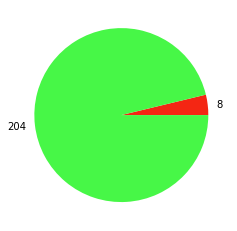

In [14]:
pyplot.pie([outputLog['errors'], outputLog['total']], labels=[outputLog['errors'], outputLog['total']], colors=['#f42613', '#47f747'])